In [12]:
import pickle, tensorflow as tf, numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    Embedding,
    SpatialDropout1D,
    Bidirectional,
    LSTM,
    TimeDistributed,
    Dense,
    
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter
from itertools import zip_longest

In [13]:
data = []
with open("../dataset/ner_srl_without_bio.tsv", encoding="utf-8") as f:
    tok, ner, srl = [], [], []
    for line in f:
        line = line.strip()
        if not line:
            if tok:
                data.append({"tokens": tok, "labels_ner": ner, "labels_srl": srl})
                tok, ner, srl = [], [], []
        else:
            t, n, s = line.split("\t")
            tok.append(t.lower())
            ner.append(n.strip())
            srl_label = s.strip()
            if srl_label == "MISC":
                srl_label = "O"
            srl.append(srl_label)


print("total kalimat ", len(data))
# ——————————————————
sentences = [d["tokens"] for d in data]
labels_ner = [d["labels_ner"] for d in data]
labels_srl = [d["labels_srl"] for d in data]

ner_counter = Counter(label for seq in labels_ner for label in seq)

srl_counter = Counter(label for seq in labels_srl for label in seq)


print(f"{'NER Label':<15} {'Count':<10} || {'SRL Label':<15} {'Count':<10}")
print("-" * 55)

for (ner_label, ner_count), (srl_label, srl_count) in zip_longest(ner_counter.items(), srl_counter.items(), fillvalue=('', '')):
    print(f"{ner_label:<15} {ner_count:<10} || {srl_label:<15} {srl_count:<10}")

total kalimat  2231
NER Label       Count      || SRL Label       Count     
-------------------------------------------------------
O               11464      || O               5702      
TIME            349        || ARGM-TMP        2089      
PER             1951       || ARG0            2637      
LOC             2184       || V               2461      
DATE            1461       || ARG1            2879      
ETH             430        || ARGM-LOC        2090      
EVENT           304        || ARG2            547       
MISC            466        || ARGM-MOD        78        
ORG             317        || ARGM-MNR        200       
                           || ARGM-NEG        19        
                           || ARGM-DIR        41        
                           || ARGM-CAU        146       
                           || ARG3            37        


In [14]:


def calculate_o_percentage(labels):
    counter = Counter(label for seq in labels for label in seq)
    total = sum(counter.values())
    count_o = counter.get("O", 0)
    percent_o = (count_o / total) * 100 if total > 0 else 0
    return percent_o, total, count_o

# Hitung persentase 'O' untuk NER
o_ner_percent, total_ner, o_ner_count = calculate_o_percentage(labels_ner)

# Hitung persentase 'O' untuk SRL
o_srl_percent, total_srl, o_srl_count = calculate_o_percentage(labels_srl)

print(f"NER  -> Total Labels: {total_ner}, O Count: {o_ner_count}, O Percentage: {o_ner_percent:.2f}%")
print(f"SRL  -> Total Labels: {total_srl}, O Count: {o_srl_count}, O Percentage: {o_srl_percent:.2f}%")


NER  -> Total Labels: 18926, O Count: 11464, O Percentage: 60.57%
SRL  -> Total Labels: 18926, O Count: 5702, O Percentage: 30.13%


In [15]:
PAD_TOKEN = "<PAD>"
words = sorted({w for s in sentences for w in s})

ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

ner_tags.insert(0, PAD_TOKEN)
srl_tags.insert(0, PAD_TOKEN)

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}


In [16]:
X = [[word2idx.get(w, 1) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = max(map(len, X))
pad_id = tag2idx_ner[PAD_TOKEN]

X = pad_sequences(X, maxlen=maxlen, padding="post", value=0)
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=pad_id)
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=pad_id)

mask = (y_ner != pad_id).astype("float32")

In [17]:
splits = train_test_split(
    X,
    y_ner,
    y_srl,
    mask,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)
X_tr, X_te, ner_tr, ner_te, srl_tr, srl_te, m_tr, m_te = splits

In [18]:
embed_dim = 64
lstm_units = 64
drop_embed = 0.2
drop_lstm = 0.2

inp = Input(shape=(maxlen,), name="tokens")
emb = Embedding(len(word2idx), embed_dim, mask_zero=True, name="embed")(inp)
emb = SpatialDropout1D(drop_embed)(emb)

x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(emb)
x = Bidirectional(
    LSTM(
        lstm_units,
        return_sequences=True,
        dropout=drop_lstm,
        recurrent_dropout=drop_lstm,
    )
)(x)

ner_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
ner_out = TimeDistributed(
    Dense(len(tag2idx_ner), activation="softmax"), name="ner_output"
)(ner_head)

srl_head = TimeDistributed(Dense(lstm_units, activation="relu"))(x)
srl_out = TimeDistributed(
    Dense(len(tag2idx_srl), activation="softmax"), name="srl_output"
)(srl_head)

model = Model(inp, [ner_out, srl_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss={
        "ner_output": "sparse_categorical_crossentropy",
        "srl_output": "sparse_categorical_crossentropy",
    },
    metrics={
        "ner_output": ["sparse_categorical_accuracy"],
        "srl_output": ["sparse_categorical_accuracy"],
    },
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tokens (InputLayer) │ (None, 38)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 38, 64)    │    158,720 │ tokens[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 38, 64)    │          0 │ embed[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 38)        │          0 │ tokens[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 38, 128)   │     66,048 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 38, 128)   │     98,816 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 38, 64)    │      8,256 │ bidirectional_3[… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 38, 64)    │      8,256 │ bidirectional_3[… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 38, 10)    │        650 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 38, 14)    │        910 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 341,656 (1.30 MB)

 Trainable params: 341,656 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    X_tr,
    [ner_tr, srl_tr],  # y → LIST (pos 0 = ner_output, 1 = srl_output)
    sample_weight=[m_tr, m_tr],  # sama‑persis urutan
    validation_data=(X_te, [ner_te, srl_te], [m_te, m_te]),
    
    batch_size=64,
    epochs=50,
    callbacks=callbacks,
    verbose=1,
)


# =========================
# 7.  Save artefacts
# =========================
model.save("lstm_ner_srl_model.keras")
for fname, obj in [
    ("word2idx.pkl", word2idx),
    ("tag2idx_ner.pkl", tag2idx_ner),
    ("tag2idx_srl.pkl", tag2idx_srl),
]:
    with open(fname, "wb") as f:
        pickle.dump(obj, f)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 4.9108 - ner_output_loss: 2.2818 - ner_output_sparse_categorical_accuracy: 0.2052 - srl_output_loss: 2.6290 - srl_output_sparse_categorical_accuracy: 0.1547 - val_loss: 4.6812 - val_ner_output_loss: 2.1289 - val_ner_output_sparse_categorical_accuracy: 0.1389 - val_srl_output_loss: 2.5523 - val_srl_output_sparse_categorical_accuracy: 0.0668 - learning_rate: 3.0000e-04
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.3571 - ner_output_loss: 1.9204 - ner_output_sparse_categorical_accuracy: 0.1344 - srl_output_loss: 2.4365 - srl_output_sparse_categorical_accuracy: 0.0673 - val_loss: 3.5487 - val_ner_output_loss: 1.5474 - val_ner_output_sparse_categorical_accuracy: 0.1389 - val_srl_output_loss: 2.0010 - val_srl_output_sparse_categorical_accuracy: 0.0905 - learning_rate: 3.0000e-04
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.3666 - ner_output_loss: 1.4404 - ner_output_sparse_categorical_accuracy: 0.1317 

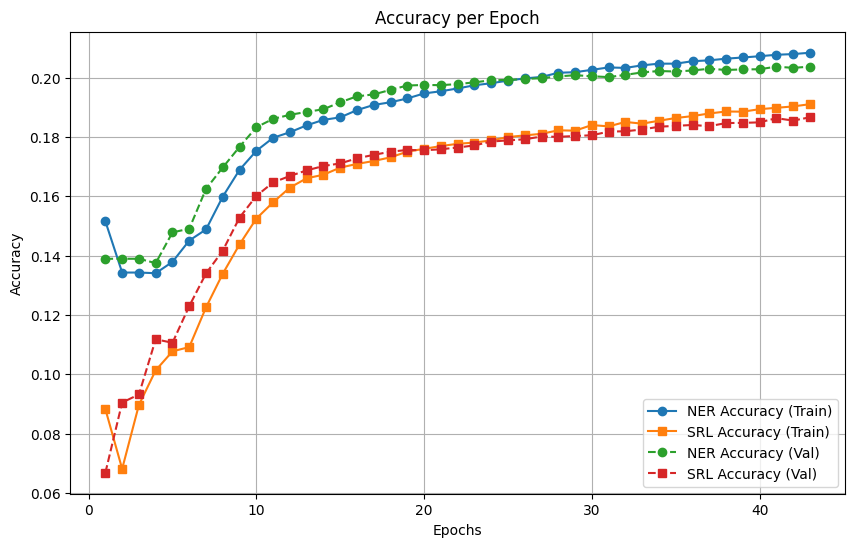

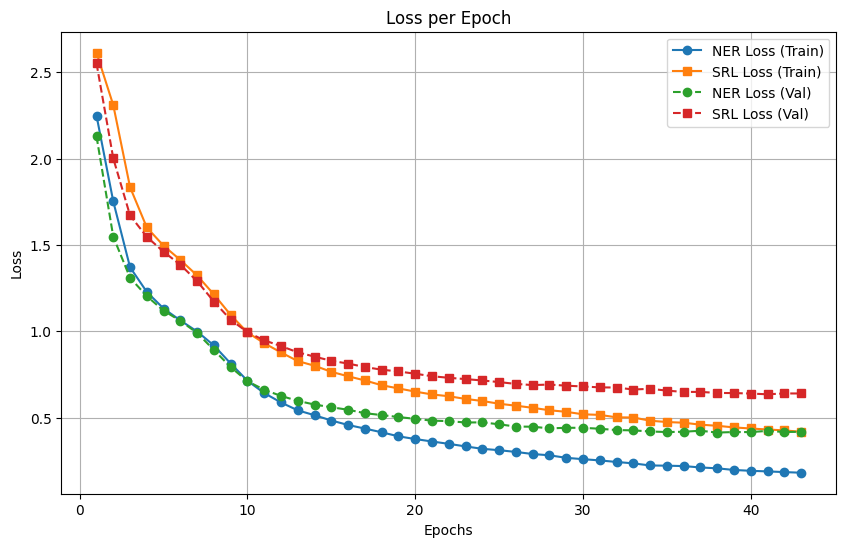

In [20]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    history_data = history.history
    epochs = range(1, len(next(iter(history_data.values()))) + 1)

    # Coba deteksi metric secara dinamis agar fleksibel
    ner_acc_key = next((k for k in history_data if "ner_output" in k and "accuracy" in k), None)
    srl_acc_key = next((k for k in history_data if "srl_output" in k and "accuracy" in k), None)
    val_ner_acc_key = f"val_{ner_acc_key}" if ner_acc_key else None
    val_srl_acc_key = f"val_{srl_acc_key}" if srl_acc_key else None

    # --- Plot Accuracy ---
    plt.figure(figsize=(10, 6))
    if ner_acc_key:
        plt.plot(epochs, history_data[ner_acc_key], marker="o", label="NER Accuracy (Train)")
    if srl_acc_key:
        plt.plot(epochs, history_data[srl_acc_key], marker="s", label="SRL Accuracy (Train)")
    if val_ner_acc_key in history_data:
        plt.plot(epochs, history_data[val_ner_acc_key], marker="o", linestyle="--", label="NER Accuracy (Val)")
    if val_srl_acc_key in history_data:
        plt.plot(epochs, history_data[val_srl_acc_key], marker="s", linestyle="--", label="SRL Accuracy (Val)")

    plt.title("Accuracy per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    plt.show()

    # --- Plot Loss ---
    plt.figure(figsize=(10, 6))
    if "ner_output_loss" in history_data:
        plt.plot(epochs, history_data["ner_output_loss"], marker="o", label="NER Loss (Train)")
    if "srl_output_loss" in history_data:
        plt.plot(epochs, history_data["srl_output_loss"], marker="s", label="SRL Loss (Train)")
    if "val_ner_output_loss" in history_data:
        plt.plot(epochs, history_data["val_ner_output_loss"], marker="o", linestyle="--", label="NER Loss (Val)")
    if "val_srl_output_loss" in history_data:
        plt.plot(epochs, history_data["val_srl_output_loss"], marker="s", linestyle="--", label="SRL Loss (Val)")

    plt.title("Loss per Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    plt.show()


plot_training_history(history)

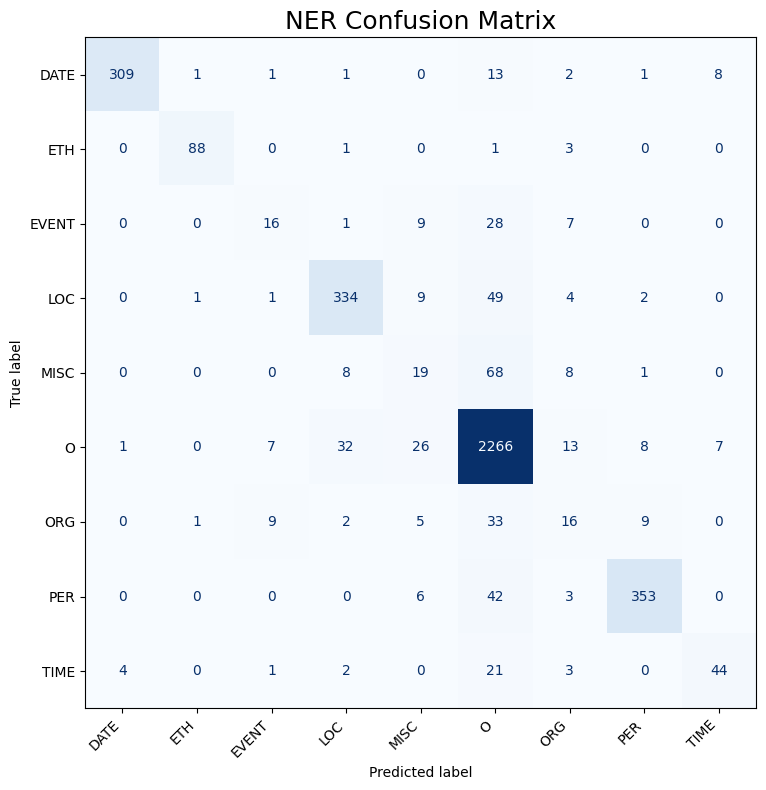

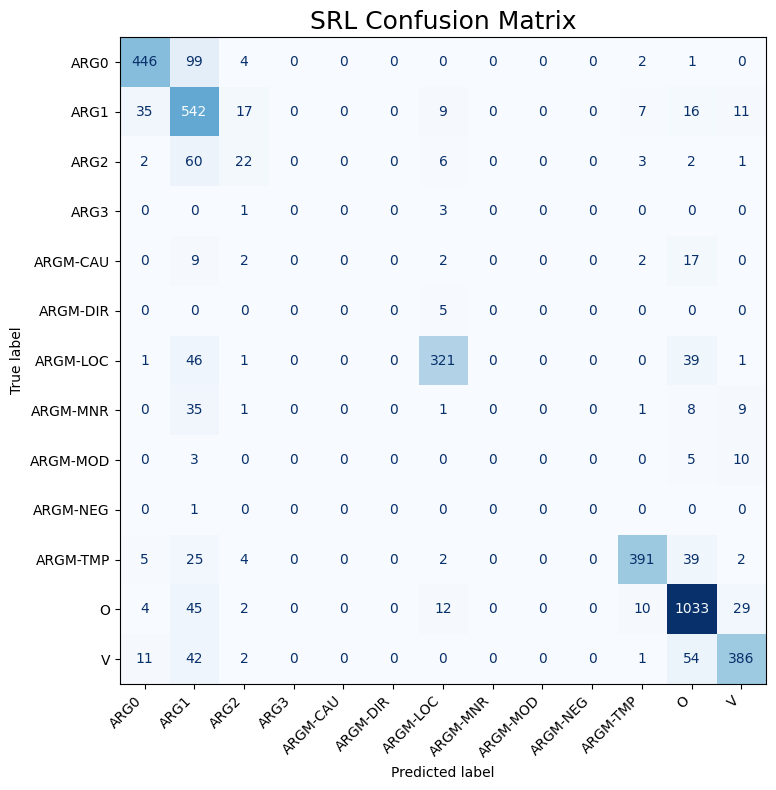


==== Confusion Matrix Manual untuk Kelas: DATE ====
               Prediksi Positif Prediksi Negatif
Aktual Positif         309 (TP)          27 (FN)
Aktual Negatif           5 (FP)        3567 (TN)

==== Confusion Matrix Manual untuk Kelas: ETH ====
               Prediksi Positif Prediksi Negatif
Aktual Positif          88 (TP)           5 (FN)
Aktual Negatif           3 (FP)        3812 (TN)

==== Confusion Matrix Manual untuk Kelas: EVENT ====
               Prediksi Positif Prediksi Negatif
Aktual Positif          16 (TP)          45 (FN)
Aktual Negatif          19 (FP)        3828 (TN)

==== Confusion Matrix Manual untuk Kelas: LOC ====
               Prediksi Positif Prediksi Negatif
Aktual Positif         334 (TP)          66 (FN)
Aktual Negatif          47 (FP)        3461 (TN)

==== Confusion Matrix Manual untuk Kelas: MISC ====
               Prediksi Positif Prediksi Negatif
Aktual Positif          19 (TP)          85 (FN)
Aktual Negatif          55 (FP)        3749 (TN)



In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ------------------------------------------------------------------
# 1.  Prediksi
# ------------------------------------------------------------------

model = load_model("lstm_ner_srl_model.keras")
pred_ner_prob, pred_srl_prob = model.predict(X_te, verbose=0)

pred_ner = pred_ner_prob.argmax(-1)
pred_srl = pred_srl_prob.argmax(-1)

# ------------------------------------------------------------------
# 2.  Siapkan masker PAD
# ------------------------------------------------------------------
pad_id = tag2idx_ner["<PAD>"]

mask_ner = ner_te != pad_id
mask_srl = srl_te != pad_id

true_ner_flat = ner_te[mask_ner]
pred_ner_flat = pred_ner[mask_ner]

true_srl_flat = srl_te[mask_srl]
pred_srl_flat = pred_srl[mask_srl]

# ------------------------------------------------------------------
# 3.  Hitung confusion matrix TANPA PAD
# ------------------------------------------------------------------
labels_ner_no_pad = [i for i in range(len(tag2idx_ner)) if i != pad_id]
labels_srl_no_pad = [i for i in range(len(tag2idx_srl)) if i != pad_id]

cm_ner = confusion_matrix(true_ner_flat, pred_ner_flat, labels=labels_ner_no_pad)
cm_srl = confusion_matrix(true_srl_flat, pred_srl_flat, labels=labels_srl_no_pad)

display_labels_ner = [idx2tag_ner[i] for i in labels_ner_no_pad]
display_labels_srl = [idx2tag_srl[i] for i in labels_srl_no_pad]

# ------------------------------------------------------------------
# 4.  Plot NER CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
disp_ner = ConfusionMatrixDisplay(confusion_matrix=cm_ner, display_labels=display_labels_ner)
disp_ner.plot(include_values=True, values_format="d", cmap=plt.cm.Blues, ax=ax, colorbar=False)
ax.set_title("NER Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5.  Plot SRL CM (tanpa PAD)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))
disp_srl = ConfusionMatrixDisplay(confusion_matrix=cm_srl, display_labels=display_labels_srl)
disp_srl.plot(include_values=True, values_format="d", cmap=plt.cm.Blues, ax=ax, colorbar=False)
ax.set_title("SRL Confusion Matrix", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6.  Manual Confusion Table untuk Thesis (NER)
# ------------------------------------------------------------------
def manual_confusion_table(true_labels, pred_labels, labels, label_names):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    for i, label in enumerate(labels):
        label_name = label_names[i]

        tp = np.sum((true_labels == label) & (pred_labels == label))
        fn = np.sum((true_labels == label) & (pred_labels != label))
        fp = np.sum((true_labels != label) & (pred_labels == label))
        tn = np.sum((true_labels != label) & (pred_labels != label))

        table = pd.DataFrame({
            'Prediksi Positif': [f'{tp} (TP)', f'{fp} (FP)'],
            'Prediksi Negatif': [f'{fn} (FN)', f'{tn} (TN)']
        }, index=['Aktual Positif', 'Aktual Negatif'])

        print(f"\n==== Confusion Matrix Manual untuk Kelas: {label_name} ====")
        print(table.to_string())

# Jalankan untuk semua kelas NER
for label_id, label_name in zip(labels_ner_no_pad, display_labels_ner):
    manual_confusion_table(true_ner_flat, pred_ner_flat, [label_id], [label_name])
    
for label_id, label_name in zip(labels_srl_no_pad, display_labels_srl):
    manual_confusion_table(true_srl_flat, pred_srl_flat, [label_id], [label_name])


In [22]:
from sklearn.metrics import accuracy_score, classification_report

# ------------------------------------------------------------------
# 3b.  Akurasi token‑level (tanpa PAD)
# ------------------------------------------------------------------
acc_ner = accuracy_score(true_ner_flat, pred_ner_flat)
acc_srl = accuracy_score(true_srl_flat, pred_srl_flat)

print(f"NER TAG accuracy : {acc_ner:.2%}")
print(f"SRL TAG accuracy : {acc_srl:.2%}")

NER TAG accuracy : 88.15%
SRL TAG accuracy : 80.37%


In [23]:

print("\n[NER] Classification report:")
print(
    classification_report(
        true_ner_flat,
        pred_ner_flat,
        labels=labels_ner_no_pad,
        target_names=display_labels_ner,
        digits=2,
    )
)


[NER] Classification report:
              precision    recall  f1-score   support

        DATE       0.98      0.92      0.95       336
         ETH       0.97      0.95      0.96        93
       EVENT       0.46      0.26      0.33        61
         LOC       0.88      0.83      0.86       400
        MISC       0.26      0.18      0.21       104
           O       0.90      0.96      0.93      2360
         ORG       0.27      0.21      0.24        75
         PER       0.94      0.87      0.91       404
        TIME       0.75      0.59      0.66        75

    accuracy                           0.88      3908
   macro avg       0.71      0.64      0.67      3908
weighted avg       0.87      0.88      0.87      3908



In [24]:
print("\n[SRL] Classification report:")
print(
    classification_report(
        true_srl_flat,
        pred_srl_flat,
        labels=labels_srl_no_pad,
        target_names=display_labels_srl,
        digits=2,
    )
)


[SRL] Classification report:
              precision    recall  f1-score   support

        ARG0       0.88      0.81      0.84       552
        ARG1       0.60      0.85      0.70       637
        ARG2       0.39      0.23      0.29        96
        ARG3       0.00      0.00      0.00         4
    ARGM-CAU       0.00      0.00      0.00        32
    ARGM-DIR       0.00      0.00      0.00         5
    ARGM-LOC       0.89      0.78      0.83       409
    ARGM-MNR       0.00      0.00      0.00        55
    ARGM-MOD       0.00      0.00      0.00        18
    ARGM-NEG       0.00      0.00      0.00         1
    ARGM-TMP       0.94      0.84      0.88       468
           O       0.85      0.91      0.88      1135
           V       0.86      0.78      0.82       496

    accuracy                           0.80      3908
   macro avg       0.42      0.40      0.40      3908
weighted avg       0.79      0.80      0.79      3908



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [25]:
# def plot_training_history(history):
#     epochs = range(1, len(history['loss']) + 1)

#     plt.figure(figsize=(14, 6))

#     # Plot Loss
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, history['loss'], label='Training Loss')
#     plt.plot(epochs, history['val_loss'], label='Validation Loss')
#     plt.title('Loss During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot Accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, history['ner_output_accuracy'], label='NER Train Acc')
#     plt.plot(epochs, history['val_ner_output_accuracy'], label='NER Val Acc')
#     plt.plot(epochs, history['srl_output_accuracy'], label='SRL Train Acc')
#     plt.plot(epochs, history['val_srl_output_accuracy'], label='SRL Val Acc')
#     plt.title('Accuracy During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# plot_training_history(history.history)

In [26]:
# def token_level_accuracy(y_true, y_pred):
#     total, correct = 0, 0
#     for true_seq, pred_seq in zip(y_true, y_pred):
#         for t, p in zip(true_seq, pred_seq):
#             if t.sum() == 0:
#                 continue
#             total += 1
#             if t.argmax() == p.argmax():
#                 correct += 1
#     return correct / total

# def decode_predictions(pred, true, idx2tag):
#     true_out, pred_out = [], []
#     for pred_seq, true_seq in zip(pred, true):
#         t_labels, p_labels = [], []
#         for p_tok, t_tok in zip(pred_seq, true_seq):
#             if t_tok.sum() == 0:
#                 continue
#             t_labels.append(idx2tag[t_tok.argmax()])
#             p_labels.append(idx2tag[p_tok.argmax()])
#         true_out.append(t_labels)
#         pred_out.append(p_labels)
#     return true_out, pred_out

# results = model.evaluate(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}, verbose=0)
# for name, value in zip(model.metrics_names, results):
#     print(f"{name}: {value}")

# y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

# true_ner, pred_ner = decode_predictions(y_pred_ner, y_ner_test, idx2tag_ner)
# true_srl, pred_srl = decode_predictions(y_pred_srl, y_srl_test, idx2tag_srl)

# acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
# acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

# print(f"NER Token Accuracy {acc_ner:.2%}")
# print(f"SRL Token Accuracy {acc_srl:.2%}")

In [27]:
# print("[NER] Classification Report:")
# print(classification_report(true_ner, pred_ner, digits=2))

In [28]:
# print("SRL Classification Resport:")
# print(classification_report(true_srl, pred_srl, digits=2))